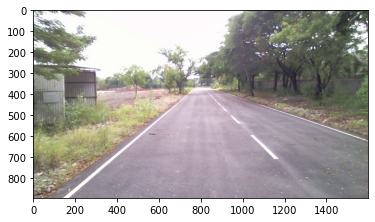

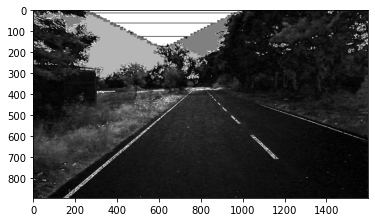

In [1]:

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import glob
import collections
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

image = mpimg.imread('back_gate_lane/image1.jpg')
plt.figure()
plt.imshow(image)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
plt.figure()
plt.imshow(s_channel, cmap = 'gray')

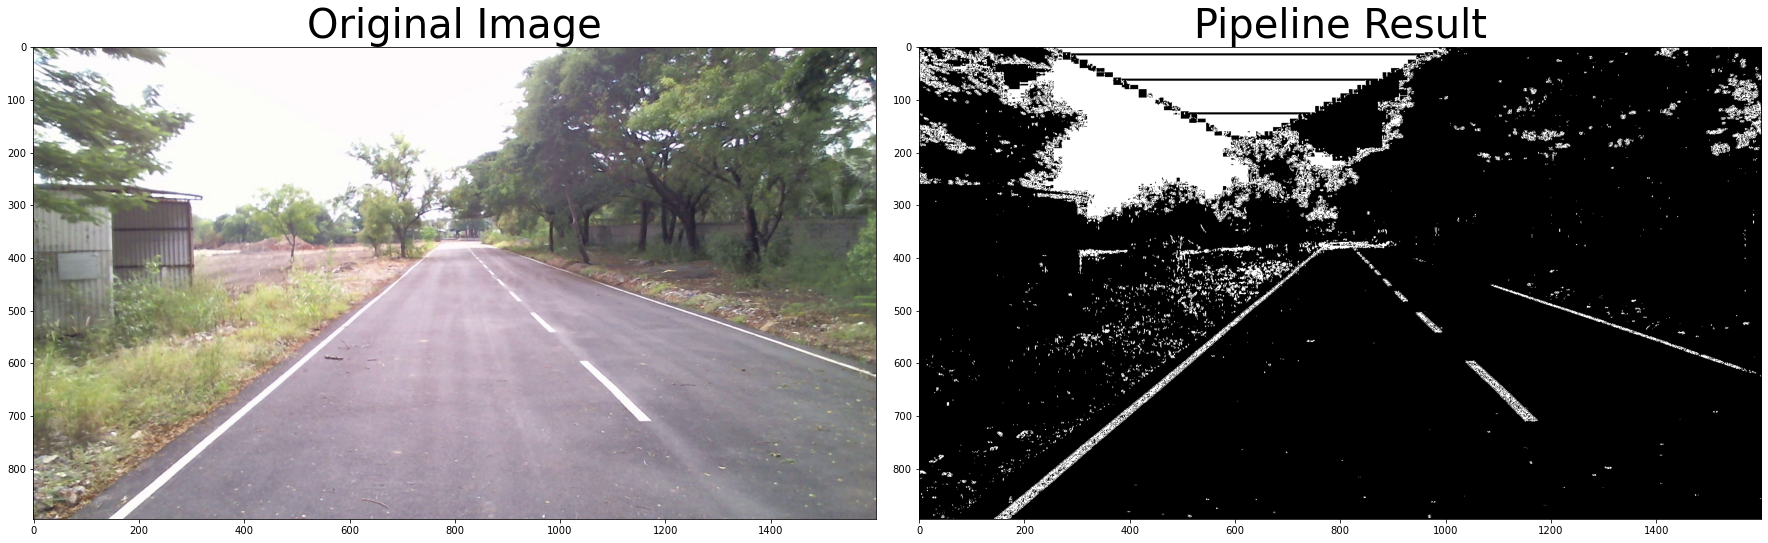

In [2]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
img = np.copy(image)
combined = pipeline(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(combined, cmap = 'gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Text(0.5, 1.0, 'After Perspective Transform')

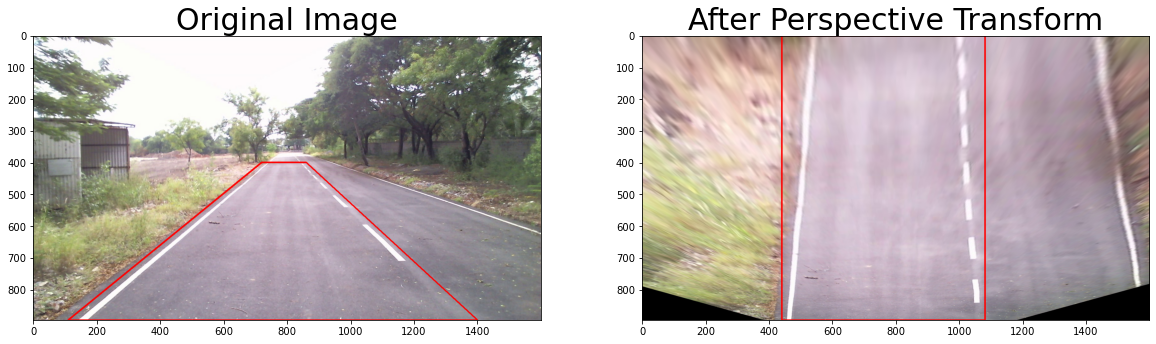

In [3]:
def perspective_trans(img):
    sizex = img.shape[0] # 720
    sizey = img.shape[1] # 1280
    src = np.float32([[720,400], [110,896], [1400, 896],[860,400]])
    dst = np.float32([[440,1], [440,896], [1080, 896],[1080,1]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (sizey, sizex), flags=cv2.INTER_LINEAR)
    #gray = (0.2989*warped[:,:,0] + 0.5870*warped[:,:,1] + 0.1140*warped[:,:,2])/3.0
    return {'warped':warped, 'dst':dst, 'src':src, 'Minv': Minv}

#img =  mpimg.imread('back_gate_lane/image1.jpg')
img= mpimg.imread('back_gate_lane/image1.jpg')

persp_obj = perspective_trans(img)
warped = persp_obj['warped']
dst = persp_obj['dst']
src = persp_obj['src']
Minv = persp_obj['Minv'] # save for use in step 6

pts1 = np.array(src, np.int32)
pts1 = pts1.reshape((-1,1,2))
cv2.polylines(img,[pts1],True,(255,0,0),3)

pts2 = np.array(dst, np.int32)
pts2 = pts2.reshape((-1,1,2))
cv2.polylines(warped,[pts2],True,(255,0,0),3)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('After Perspective Transform', fontsize=30)


In [4]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh= (0,255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def s_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# Define a function that thresholds the h-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def h_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    
    # 2) Apply a threshold to the h channel
    binary_output = np.zeros_like(h)
    binary_output[(h > thresh[0]) & (h <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# Define a function that takes in chessboard size, paths to open/save images 
# and returns objpoints/imgpoints to undistort an image.
def curvature_eval(binary_warped, nwindows = 20, margin = 50, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # nwindows = the number of sliding windows
    # margin = width of the windows +/- margin
    # minpix = minimum number of pixels found to recenter window
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 4.05/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate radii of curvature
    y_eval = binary_warped.shape[0] - 1 # position at which curvature is calculated
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate offset of car assuming dashcam is mounted at car centerline
    offset_val = xm_per_pix * 0.5 * (binary_warped.shape[1] - (leftx_base + rightx_base))
    
    if offset_val < 0:
        offset_dir = 'left'
    else:
        offset_dir = 'right'
    offset = {'offset_val':offset_val, 'offset_dir':offset_dir}
    
    return {'left_fit':left_fit,'right_fit':right_fit, 'nonzerox':nonzerox,'nonzeroy':nonzeroy,\
            'left_lane_inds':left_lane_inds,'right_lane_inds':right_lane_inds,\
            'left_curverad':left_curverad, 'right_curverad':right_curverad,\
            'right_fit_cr':right_fit_cr,'offset':offset, 'out_img':out_img }
# Projects the identified lane lines back down to the road
def map_color(Minv, warped, undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

# Define a function that takes curvature, offset and maps them onto a frame
def map_curv(img, curvature, offset):
    font = cv2.FONT_HERSHEY_SIMPLEX;
    offset_val = offset['offset_val']
    offset_dir = offset['offset_dir']
    curv_text = 'Radius of curvature is: ' + str(curvature) + ' m' 
    offset_text = 'Car is offset: ' + str(abs(offset_val)) + ' m towards ' + offset_dir
    cv2.putText(img, curv_text, (50, 50), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img, offset_text, (50, 100), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    return img

The radius of curvature is: 9731.506162509044
The car is offset 0.25457142857142856 towards right.


Text(0.5, 1.0, 'Lane lines identified')

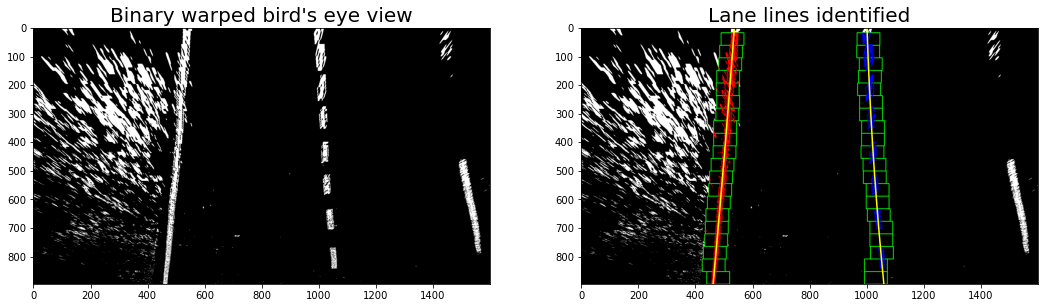

In [5]:
# Step 4. Find lane line pixels in a binary warped image and fit 2nd order polynomial
# Step 5. Find radius of curvature and offset of vehicle from lane centerline
pers_obj2 = perspective_trans(combined)
binary_warped = pers_obj2['warped']
curv_obj = curvature_eval(binary_warped, nwindows = 20, margin = 40, minpix = 50)
left_fit = curv_obj['left_fit']
right_fit = curv_obj['right_fit']
nonzerox = curv_obj['nonzerox']
nonzeroy = curv_obj['nonzeroy']
left_lane_inds = curv_obj['left_lane_inds']
right_lane_inds = curv_obj['right_lane_inds']
offset = curv_obj['offset']
out_img = curv_obj['out_img']
curvature = 0.5 * (curv_obj['left_curverad'] + curv_obj['right_curverad'])
print('The radius of curvature is: ' + str(curvature))
print('The car is offset ' + str(offset['offset_val']) + ' towards ' + offset['offset_dir'] + '.')

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,9))
ax1.imshow(binary_warped, cmap = 'gray')
ax1.set_title('Binary warped bird\'s eye view', fontsize = 20)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Lane lines identified', fontsize = 20)

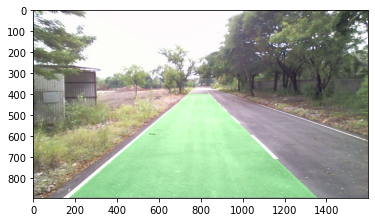

In [69]:
plt.imshow(map_color(Minv, binary_warped, image, left_fitx, right_fitx, ploty))

In [6]:
def process_img(img, M_inv=Minv, ksize=5, nwindows=40, margin=40, minpix=40):
    # Step 1. Undistort image
    und_img = img 
    # Step 2. Apply each of the thresholding functions
    gradx = abs_sobel_thresh(und_img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(und_img, sobel_kernel=ksize, mag_thresh=(50, 100))
    s_binary = s_select(und_img, thresh=(150, 255))
    combined = np.zeros_like(gradx)
    combined[(((gradx == 1) & (mag_binary == 1))| (s_binary == 1))] = 1
    # Step 3. Perform a perspective transform
    persp_obj = perspective_trans(combined)
    warped = persp_obj['warped']
    Minv = persp_obj['Minv']
    # Step 4. Find lane line pixels in a binary warped image and fit 2nd order polynomial
    # Step 5. Find radius of curvature and offset of vehicle from lane centerline
    curv_obj = curvature_eval(warped, 40, 40, 40)
    left_fit = curv_obj['left_fit']
    right_fit = curv_obj['right_fit']
    left_lane_inds = curv_obj['left_lane_inds']
    right_lane_inds = curv_obj['right_lane_inds']
    offset = curv_obj['offset']
    left_curverad = curv_obj['left_curverad']
    right_curverad = curv_obj['right_curverad']
    curvature = 0.5 * (curv_obj['left_curverad'] + curv_obj['right_curverad'])
    # Step 6. Overlay identified lane on original image
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lane_img = map_color(M_inv, warped, und_img, left_fitx, right_fitx, ploty)
    lane_img = map_curv(lane_img, curvature, offset)
    return {'left_fit':left_fit, 'right_fit':right_fit, 'lane_img':lane_img, \
            'offset':offset, 'curvature':curvature, 'left_lane_inds':left_lane_inds,\
            'right_lane_inds':right_lane_inds, 'left_curverad':left_curverad,\
            'right_curverad':right_curverad, 'warped':warped, 'ploty':ploty, 'M_inv':M_inv, 'und_img':und_img}

In [77]:
class MyVideoProcessor(object):

    # constructor function
    def __init__(self):
        # frame count
        self.count = 0
        # values of the last 10 fits of the line
        self.past_frames_left = collections.deque(maxlen=10)
        self.past_frames_right = collections.deque(maxlen=10)

        # values of fits of the line for previous frame
        self.last_fit_left = []
        self.last_fit_right = []

        # curvature for previous frame
        self.left_curverad = []
        self.right_curverad = []
        self.curvature = []
        
        # offset for previous frame
        self.offset = []
        
        # polynomial coefficients averaged over the last n iterations
        self.best_fit_left = None 
        self.best_fit_right = None 

    def pipeline_function(self, frame):
        # your lane detection pipeline
        if self.count < 10:
            pipeline = process_img(frame)
            self.past_frames_left.append(pipeline['left_fit'])
            self.past_frames_right.append(pipeline['right_fit'])
            if self.count == 9:
                self.last_fit_left = pipeline['left_fit']
                self.last_fit_right = pipeline['right_fit']
                self.left_curverad = pipeline['left_curverad']
                self.right_curverad = pipeline['right_curverad']
                self.curvature = pipeline['curvature']
                self.offset = pipeline['offset']
                self.best_fit_left = np.mean(self.past_frames_left, axis = 0)
                self.best_fit_right = np.mean(self.past_frames_right, axis = 0)
            self.count += 1
            return pipeline['lane_img']
        
        else:
            # retrieve stored vals from previous frame
            previous_left_fit = self.last_fit_left
            previous_right_fit = self.last_fit_right
            previous_left_curv = self.left_curverad
            previous_right_curv = self.right_curverad
            previous_curvature = self.curvature
            previous_offset = self.offset
            avg_left_fit = self.best_fit_left
            avg_right_fit = self.best_fit_right
            y_delx = frame.shape[0] - 1
            prev_delx = abs(avg_left_fit[0]*y_delx**2 + avg_left_fit[1]*y_delx + avg_left_fit[2] \
            - avg_right_fit[0]*y_delx**2 + avg_right_fit[1]*y_delx + avg_right_fit[2])
            
            # process and evaluate vals for current frame
            pipeline = process_img(frame)
            und_img = pipeline['und_img']
            current_left_fit = pipeline['left_fit']
            current_right_fit = pipeline['right_fit']
            current_left_curv = pipeline['left_curverad']
            current_right_curv = pipeline['right_curverad']
            current_curvature = pipeline['curvature']
            current_offset = pipeline['offset']
            current_delx = abs(current_left_fit[0]*y_delx**2 + current_left_fit[1]*y_delx + current_left_fit[2] \
            - current_right_fit[0]*y_delx**2 + current_right_fit[1]*y_delx + current_right_fit[2])         

            if (current_left_fit.shape[0] == 0) | (current_right_fit.shape[0] == 0) | \
             (abs(current_curvature) > 10000) | (abs(current_curvature) < 800) | (current_delx > 1550) | (current_delx < 1100):
                current_left_fit = avg_left_fit
                current_right_fit = avg_right_fit
                current_curvature = previous_curvature
                current_offset = previous_offset
                
            self.past_frames_left.append(current_left_fit)
            self.past_frames_right.append(current_right_fit)
            current_avg_left_fit = np.mean(self.past_frames_left, axis = 0)
            current_avg_right_fit = np.mean(self.past_frames_right, axis = 0) 
            self.best_fit_left = current_avg_left_fit 
            self.best_fit_right = current_avg_right_fit
            self.curvature = current_curvature
            self.offset = current_offset
            
            M_inv = pipeline['M_inv']
            warped = pipeline['warped']
            ploty = pipeline['ploty']
            left_fitx = current_avg_left_fit[0]*ploty**2 + current_avg_left_fit[1]*ploty + current_avg_left_fit[2]
            right_fitx = current_avg_right_fit[0]*ploty**2 + current_avg_right_fit[1]*ploty + current_avg_right_fit[2]
            lane_img = map_color(M_inv, warped, und_img, left_fitx, right_fitx, ploty)
            lane_img = map_curv(lane_img, current_curvature, current_offset)
            self.count += 1
            return lane_img

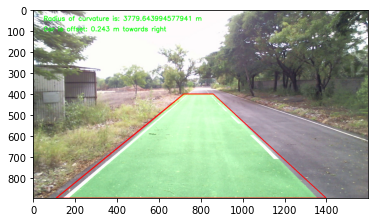

In [82]:
process_img_obj = process_img(img, Minv, 5, 40, 40, 40)
plt.imshow(process_img_obj['lane_img'])

In [85]:
my_video_processor_object = MyVideoProcessor()
output = 'output.mp4'
clip = VideoFileClip("back_gate_lane/back_gate_lane.mp4")

white_clip = clip.fl_image(my_video_processor_object.pipeline_function)

%time white_clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

t:   0%|                                                                            | 0/3378 [00:00<?, ?it/s, now=None]

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
Wall time: 14min 38s
